# Feature engineering

In this session we will practice extracting and transforming features from MEG data and from text data. We will also be checking how our features work with classification algorithms.

## Magnetoencephalography

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/NIMH_MEG.jpg/435px-NIMH_MEG.jpg" width=300px>

Magnetoencephalography (MEG) is a functional neuroimaging technique for mapping brain activity by recording magnetic fields produced by electrical currents occurring naturally in the brain, using very sensitive magnetometers (https://en.wikipedia.org/wiki/Magnetoencephalography).


### MEG dataset

The original dataset comes from http://www.cis.hut.fi/icann2011/mindreading.php

- Subject watches video clips
  - artificial, football, nature, Mr Bean, Chaplin
- MEG recorded
  - 1 second @ 200Hz
  - 204 channels
- Experiment repeated on another day
- Task: brain decoding
  - given MEG recording, guess category of video
  
Let's load the data.  

**NOTE** if you kernel gets killed, make sure to close other open notebooks. Or use a subset of the data.

If you want to download the data, you can copy it to your home directory by executing the following command in a notebook.
```
!cp -r /srv/megicann .
```

In [1]:
import numpy as np
# Use a subset of data because of server limits
train_signal = np.load("/srv/megicann/train_signal.npy")
valid_signal = np.load("/srv/megicann/valid_signal.npy")
y_train = np.load("/srv/megicann/train_target.npy")
y_valid = np.load("/srv/megicann/valid_target.npy")

In [2]:
print(train_signal.shape)

(677, 204, 200)


And let's plot a few of the channels.

Text(0.5, 0, 'Time')

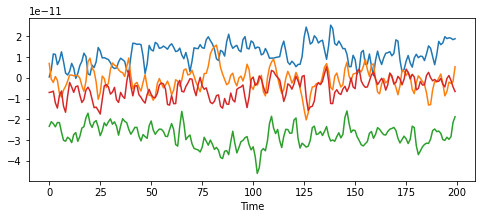

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
for i in [0, 10, 100, 200]:
    plt.plot(train_signal[0,i,:])
plt.xlabel("Time")

We will be using a module named `rep.py` in this session, so create this file and put your function definitions in it.

### Exercise A1

Complete the function `majority` which finds out the majority baseline. The function should check which class is most common in the training data `train`, and what proportion of examples in the test data `test` belongs to this class. The output should be the ratio between these two.

Example function call `majority([0,1,0,2,0,1,0], [0,1,2,1])` should output `0.25` since the majority class in `[0,1,0,2,0,1,0]` is 0 and the proportion of examples in the test data (`[0,1,2,1]`) belonging to this majority class 0 is 0.25.

In [4]:
from rep import majority
    

print(majority(y_train, y_valid))
print(majority(y_train, y_train))
print(majority([0,1,0,2,0,1,0], [0,1,2,1]))

0.2
0.25258493353028066
0.25


### Exercise A2

Complete function `features_mean` which extracts and returns time-wise means of a multichannel singal. The input signal is a three-dimensional array of shape `(example, channel, time)`. The output should be a two-dimensional array of shape `(example, channel)`.

For example, if the shape of the signal is `(677, 204, 200)`, the shape of the output of `features_mean(signal)` should be `(677, 204).`

In [5]:
from rep import features_mean

### Exercise A3

Evaluate the performance of the scikit-learn `LogisticRegression` classifier on the MEG data by using time-wise mean per channel (output of applying `features_mean` function on the signal) as the input features. Train on the training data and evaluate on the validation data. Set `random_state` to 123. You can change regularization strength by using the `C` parameter.


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
X_train = features_mean(train_signal)
X_valid = features_mean(valid_signal)
for C in [0.1, 1.0, 10.0]:
        model = LogisticRegression(random_state=123, C=C)
        model.fit(X_train, y_train)
        acc = accuracy_score(y_valid, model.predict(X_valid))
        print("{}\t {}".format(C, acc))


0.1	 0.2
1.0	 0.2
10.0	 0.2


### Exercise A4

Complete function `features` below, which takes a signal (as a three-dimensional array), a list of feature functions, and returns an array with all the features extracted by the functions, concatenated together. Each feature function in the list can be applied to a 3-dimensional signal of shape `(example, channel, time)`, and will reduce it to a two-dimensional array along the axis specified via the `axis` keyword argument.

You may find the function `np.concatenate` useful.

Furthermore, you can fill the list of feature functions with functions such as: np.mean, np.min etc.

For example, given the `train_signal` of size `(677,204,200)` and set of functions `summaries = [np.mean, np.min, np.max, np.std]` as inputs, `features` function applies the functions in `summaries` to `train_signal` along the last (2nd) axis. Note that since each function (np.min, np.mean, etc.) will produce an output of size `(677,204)`, you will concatenate these outputs so that the results the shape of the `X_train` will be `(677, 204 * number of elements in summaries)` after the call `X_train = features(train_signal, summaries)
`.

In [7]:
from rep import features

summaries = [np.mean, np.min, np.max, np.std]

X_train = features(train_signal, summaries)
print("Input shape {}".format(train_signal.shape))
print("The resulting shape should be {}".format(
        (train_signal.shape[0], train_signal.shape[1]*len(summaries))))
print(X_train.shape)

Input shape (677, 204, 200)
The resulting shape should be (677, 816)
(677, 816)


### Exercise A5 

Compute the performance of the `LogisticRegression` classifier on the full set of summary features. Then leave out each feature in turn and calculate the change in performance. 
Standardize your feature data by using StandardScaler from `sklearn.preprocessing` before training with `LogisticRegression`. Again you can use 123 as the `random_state`.
When evaluating the model print the left out feature and the corresponding accuracy on the test set.

For example, if your initial function set is `summaries = [np.mean, np.min, np.max, np.std]`, you will leave out one of them (e.g. `np.mean`) at each iteration and perform the training with the remaining ones `(e.g. [np.min, np.max, np.std])`. At each iteration print the left out feature and the corresponding accuracy on the test set.

(If the optimizer doesn't converge, we can increase the number of iterations via the argument `max_iter`.)

In [8]:
# ...........................................
def evaluate(X, y, X_val, y_val):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_val = scaler.transform(X_val)
    model = LogisticRegression(random_state=123, C=1.0, max_iter=200)
    model.fit(X, y)
    acc = accuracy_score(y_val, model.predict(X_val))
    return acc

from sklearn.preprocessing import StandardScaler


X_train = features(train_signal, summaries)
X_valid = features(valid_signal, summaries)
acc = evaluate(X_train, y_train, X_valid, y_valid)
print("All {}".format(acc))

for i in range(len(summaries)):
    fs = summaries[:i] + summaries[i+1:]
    X_train = features(train_signal, fs)
    X_valid = features(valid_signal, fs)
    this = evaluate(X_train, y_train, X_valid, y_valid)
    print("{} {}".format(summaries[i].__name__, this))


All 0.52
mean 0.48
amin 0.5
amax 0.52
std 0.52


## Same or different

This dataset was created by asking people to look at and describe photographs. Each example consists of a pair of descriptions, and the target is either 1, if the descriptions are of the same photo, or 0 if they are of different photos.

### Loading 
We can use the `pandas.read_csv` function to load the csv files with the data.

In [9]:
import pandas as pd

In [10]:
train_input = pd.read_csv("/srv/same/same-or-diff-train-features.csv")
train_target = pd.read_csv("/srv/same/same-or-diff-train-label.csv")
test_input = pd.read_csv("/srv/same/same-or-diff-test-features.csv")
test_target = pd.read_csv("/srv/same/same-or-diff-test-label.csv")

In [11]:
train_input.head()

,Id,Sentence1,Sentence2
0,0,young boy sitting down eating a hot dog,A soccer game with players defending the ball
1,1,The lights are still on and no one is around.,"Two toilets, one with a brown lid and one with..."
2,2,there are many different signs on this street ...,some street signs on a pole next to a big buil...
3,3,BEAUTIFUL COLORED LARGE POTS FILLED WITH PLANT...,Potted plants near a park and trees.
4,4,A woman and a girl are standing beside a Chris...,Lady and child standing by Christmas tree in f...


In [12]:
train_target.head()

,Id,Prediction
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


Pandas uses data frames to store the data. We can convert these to simple lists or to numpy arrays which can be more convenient to work with.

In [13]:
y_train = np.array(train_target['Prediction'])
y_test = np.array(test_target['Prediction'])

In [14]:
print(y_train.shape)
print(y_test.shape)

(180000,)
(10000,)


In [15]:
train_text = np.array(train_input[['Sentence1', 'Sentence2']])
test_text = np.array(test_input[['Sentence1', 'Sentence2']])

In [16]:
train_text[:,0]

array(['young boy sitting down eating a hot dog',
       'The lights are still on and no one is around.',
       'there are many different signs on this street pole', ...,
       'A computer desk has two monitors and a desk chair.',
       'A young woman is dressed in gothic clothing. ',
       'Men in a park with frisbee, with trees, portable toilets, fence, bags, and other people in background.'],
      dtype=object)

### Exercise B1
Complete the following function `counts` which extracts word counts from both columns of the same-of-different dataset.
The function counts should return 2 sparse matrices, one containing the word count for `train_text` and the other for `test_text`.

Hint: 
You can use CountVectorizer to convert a text document to a matrix of token counts. 
Take a look at the documentation for CountVectorizer:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [17]:
from rep import counts


In [18]:
# Avoid killing the kernel by only using 1/10 of the data
X_train, X_test = counts(train_text[:18000], test_text)
y_train = y_train[:18000]
print(X_train.shape)
print(X_test.shape)

(18000, 12922)
(10000, 12922)


### Exercise B2

Test the performance of the LogisticRegression algorithm and the Decision Tree algorithm on the word count features. Test different values of `C` for the LogisticRegression, and several values of `max_depth` for the decision tree.

We would expect a linear classifier (including the LogisticRegression) to fail to learn this task given this feature representation, i.e. the performances should be around 50%. The decision tree, on the other hand, should be able to perform well above chance.

Use 123 as the `random_state` in both models, for `C` and `max_depth` you can use [0.1, 1.0, 10] and [5, 50, 500], but feel free to play around with them.
Make sure to print the results for both models for each setting.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

print("algo setting accuracy")
for C in [0.1, 1.0, 10.0]:
    model = LogisticRegression(C=C, random_state=123, max_iter=50)
    model.fit(X_train, y_train)
    print("logreg C={} {}".format(C, accuracy_score(y_test, model.predict(X_test))))
    
for depth in [5, 50, 500]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=123)
    model.fit(X_train, y_train)
    print("decision_tree depth={} {}".format(depth, accuracy_score(y_test, model.predict(X_test))))

algo setting accuracy


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logreg C=0.1 0.5017


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logreg C=1.0 0.5057


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logreg C=10.0 0.5043
decision_tree depth=5 0.5032
decision_tree depth=50 0.5741
decision_tree depth=500 0.6473


### Exercise B3

Cosine similarity between two vectors is equivalent to the normalized dot product:
 
 $$ cosine(u, v) = \frac{u \cdot u}{||u|| \times ||v||} $$
 
It is often used as a measure of similarity between vectors, especially when the direction the vectors are pointing to is of more interest than the magnitude.

Create a function called `cosine_feat`, which computes the cosine similarity between the word-count vectors of the two sentences in `train_text`, and separately and computes the cosine similarity between the word-count vectors of the two sentences in `test_text`.
This function should return 2 numpy arrays containing the similarity values.

For example, `X_train, X_test = cosine_feat(train_text[:18000], test_text)` computes (i) the cosine similarity between sentence pairs of `train_text[:18000]`, and (ii) the cosine similarity between sentence pairs of `test_text`. Output of (i) is returned as `X_train` and output of (ii) is returned as `X_test` in this example. Note that while obtaining the sentence representations of test set, CountVectorizer fitted to the training set should be used.


Then use this new data to train and evaluate the LogisticRegression.

**Hint:** To compute pairwise cosine distances, you can use `paired_cosine_distances` from `sklearn.metrics.pairwise`. Cosine similarity can be found as 1 - cosine distance.

In [20]:
from rep import cosine_feat

X_train, X_test = cosine_feat(train_text[:18000], test_text)

X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

print("algo setting accuracy")
for C in [0.1, 1.0, 10.0]:
    model = LogisticRegression(C=C, random_state=123)
    model.fit(X_train, y_train)
    print("logreg C={} {}".format(C, accuracy_score(y_test, model.predict(X_test))))
    
    

algo setting accuracy
logreg C=0.1 0.8026
logreg C=1.0 0.8026
logreg C=10.0 0.8026


We can check the weight and bias learned by the model like so:

In [21]:
model = LogisticRegression(C=1.0, random_state=123)
model.fit(X_train, y_train)
print(model.intercept_)
print(model.coef_)

[-2.03232168]
[[11.51298264]]



So the model has learned to classify an example as positive if `11.6 * cosine -  2 >= 0`, or equivalently, if the cosine is greater than about 0.18.